# Introduction to Bayesian Optimization

In this notebook, we'll explore the basics of Bayesian Optimization, a powerful method for optimizing black-box functions. We'll implement a simple Bayesian Optimization algorithm from scratch using basic libraries like numpy and pandas.

## Key Components
- **Objective Function**: The function we want to optimize.
- **Surrogate Model**: A model that approximates the objective function.
- **Acquisition Function**: A function that guides the search for the optimum.

![Bayesian Optimization Steps](BO_steps.jpg)

# Setting Up the Environment

Let's start by importing the necessary libraries and setting up some helper functions.

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Helper function to plot the objective function
def plot_objective(x, y):
    plt.plot(x, y, 'r:', label='Objective Function')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Objective Function')
    plt.legend()
    plt.show()


# Define the Objective Function

We'll define a simple objective function to optimize. For demonstration purposes, we'll use the function \( f(x) = -x^2 + 4 \).

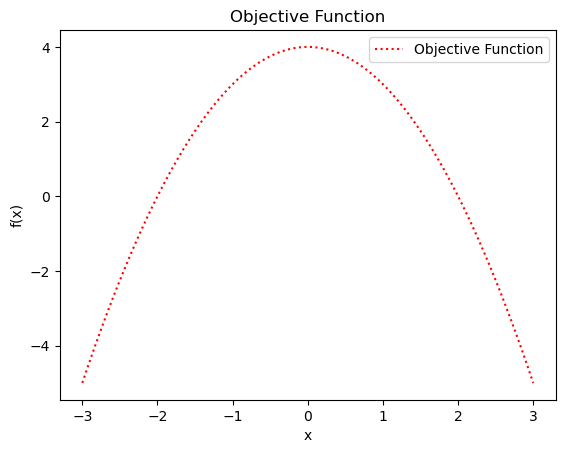

In [13]:

# Define the objective function
def objective_function(x):
    return -x**2 + 4

# Generate data points for visualization
x = np.linspace(-3, 3, 100)
y = objective_function(x)

# Plot the objective function
plot_objective(x, y)


# Surrogate Model with Gaussian Process

We'll use a Gaussian Process (GP) as our surrogate model. The GP will help us model the objective function and make predictions about its behavior.

### Gaussian Process Regression
We'll use the RBF (Radial Basis Function) kernel, which is common for GP models.

c:\Users\taylo\miniconda3\envs\MatInformatics2\Lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


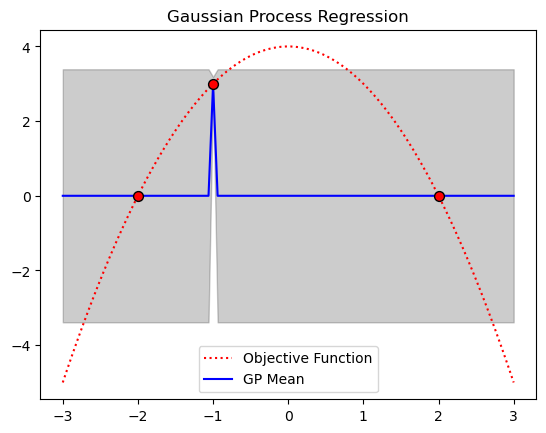

In [14]:

# Define the Gaussian Process with RBF kernel
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit to some initial samples (example points)
x_sample = np.array([[-2.], [-1.], [2.]])
y_sample = objective_function(x_sample)

gp.fit(x_sample, y_sample)

# Plot the GP prediction with the objective function
x = np.linspace(-3, 3, 100).reshape(-1, 1)
mu, sigma = gp.predict(x, return_std=True)

plt.plot(x, objective_function(x), 'r:', label='Objective Function')
plt.plot(x, mu, 'b-', label='GP Mean')
plt.fill_between(x.ravel(), mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='k')
plt.scatter(x_sample, y_sample, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()


# Acquisition Function

The acquisition function helps us decide where to sample next. One popular choice is the Expected Improvement (EI) function.

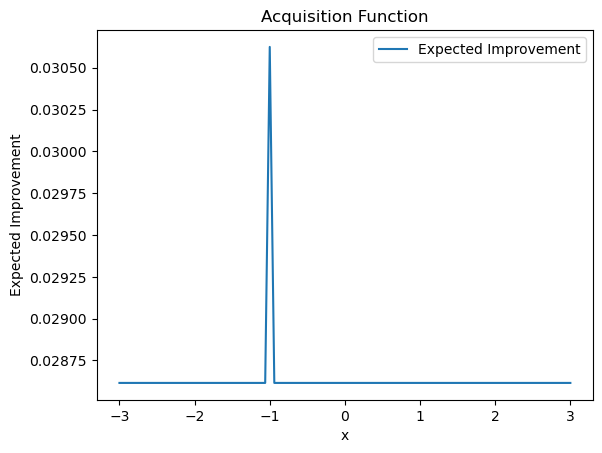

In [15]:

# Define the Expected Improvement acquisition function
def expected_improvement(x, x_sample, y_sample, gp, xi=0.01):
    mu, sigma = gp.predict(x, return_std=True)
    mu_sample_opt = np.max(y_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

# Example usage of the EI acquisition function
x = np.linspace(-3, 3, 100).reshape(-1, 1)
ei = expected_improvement(x, x_sample, y_sample, gp)

plt.plot(x, ei, label='Expected Improvement')
plt.xlabel('x')
plt.ylabel('Expected Improvement')
plt.title('Acquisition Function')
plt.legend()
plt.show()


# Bayesian Optimization Loop

In this section, we'll implement the main loop of Bayesian Optimization, which includes updating the surrogate model and optimizing the acquisition function.

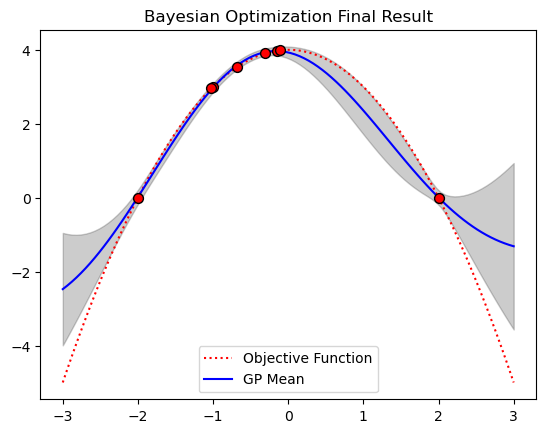

In [16]:
from scipy.optimize import minimize


# Function to propose the next sampling point
def propose_location(acquisition, x_sample, y_sample, gp, bounds, n_restarts=25):
    dim = x_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(-1, 1), x_sample, y_sample, gp)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)

# Define bounds for the search
bounds = np.array([[-3.0, 3.0]])

# Run the Bayesian Optimization loop
x_sample = np.array([[-2.], [-1.], [2.]])
y_sample = objective_function(x_sample)

gp.fit(x_sample, y_sample)

for i in range(5):
    # Propose the next sampling point
    x_next = propose_location(expected_improvement, x_sample, y_sample, gp, bounds)
    
    # Obtain the next sample from the objective function
    y_next = objective_function(x_next)
    
    # Append the sample to previous samples
    x_sample = np.vstack((x_sample, x_next))
    y_sample = np.vstack((y_sample, y_next))
    
    # Update the Gaussian Process with new samples
    gp.fit(x_sample, y_sample)

# Plot the final GP and samples
mu, sigma = gp.predict(x, return_std=True)
plt.plot(x, objective_function(x), 'r:', label='Objective Function')
plt.plot(x, mu, 'b-', label='GP Mean')
plt.fill_between(x.ravel(), mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='k')
plt.scatter(x_sample, y_sample, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title('Bayesian Optimization Final Result')
plt.legend()
plt.show()


# Visualization and Analysis

Let's visualize the results of our optimization process, including the objective function, surrogate model, and acquisition function.

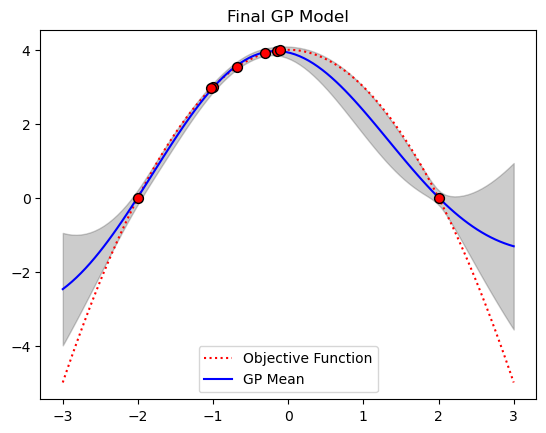

In [17]:

# Visualize the final Gaussian Process and samples
def plot_gp_final(gp, x, y, x_sample, y_sample):
    mu, sigma = gp.predict(x, return_std=True)
    plt.plot(x, y, 'r:', label='Objective Function')
    plt.plot(x, mu, 'b-', label='GP Mean')
    plt.fill_between(x.ravel(), mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='k')
    plt.scatter(x_sample, y_sample, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.title('Final GP Model')
    plt.legend()
    plt.show()

# Plot the final results
plot_gp_final(gp, x, objective_function(x), x_sample, y_sample)
